# Libraries

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from keras import models as m
from keras import layers as l
from keras import optimizers as o
from keras import regularizers as r
from tqdm import tqdm
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

# MNIST

After loading the MNIST datasets ({x_train, y_train} for the training of our NN and {x_test, y_test} for the evaluation of it) we reshaped the arrays x_train and x_test to four dimensions so that they could work with the Keras API. In addition, we normalized the values of the pictures in the interval [0, 1] in order to help our neural network converge faster to the solution. Needless to say that, before normalizing our data we casted their values to float so as not to lose any information.

In [2]:
# Loading the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Casting Float values so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

11493376/11490434 [==============================] - 0s 0us/step


# Discriminator

The Discriminator was based on the LeNet-5 architecture and consists of a convolutional layer with a batch-normalization layer, a max-pooling layer and a dropout layer twice followed by two fully connected layers with a softmax output of ten classes at the end. In all layers, except the output, we used LeakyReLU as activation function because it has better gradient propagation than sigmoid and tanh and tackles the dying ReLU problem with its slope. We also used batch normalization after all layers except the first convolutional layer where we used L2 regularization in an attempt to normalize the activations of the various layers and reduce overfitting. In addition we used a dropout regularization after each set of layers to reduce overfitting even more. Finally, we used max-pooling after the convolutions to reduce the computational cost, by reducing the number of parameters to learn. The reason we used a softmax activation function at the output layer is because it yields the best results when classifying between many classes.

In [3]:
discriminator = m.Sequential()

discriminator.add(l.Conv2D(32, kernel_size=5, strides=1, padding='same',
                  input_shape=(28, 28, 1), 
                  kernel_regularizer=r.l2(0.0005)))
discriminator.add(l.LeakyReLU(alpha=0.2))
discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
discriminator.add(l.Dropout(0.35))

discriminator.add(l.Conv2D(64, kernel_size=3, strides=1, padding='same',
                  use_bias=False))
discriminator.add(l.BatchNormalization())
discriminator.add(l.LeakyReLU(alpha=0.2))
discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
discriminator.add(l.Dropout(0.35))

discriminator.add(l.Flatten())

discriminator.add(l.Dense(64, use_bias=False))
discriminator.add(l.BatchNormalization())
discriminator.add(l.LeakyReLU(alpha=0.2))

discriminator.add(l.Dense(32, use_bias=False))
discriminator.add(l.BatchNormalization())
discriminator.add(l.LeakyReLU(alpha=0.2))

discriminator.add(l.Dense(10, activation='softmax'))

discriminator.summary()
# plot_model(discriminator, to_file='discriminator_plot.png',
#            show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18432     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0

# Compilation & Evaluation

For the compilation of the Discriminator we used as loss function the categorical crossentropy for we had the tags one hot encoded, as optimizer the Adam optimizer and as metrics the accuracy of the predicted images. As far as the training is concerned we had our neural network train for twenty five epochs, while enabling the shuffling of the images in the training set.

In [4]:
# Onehot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Compilation
discriminator.compile(loss='categorical_crossentropy', 
                      optimizer=o.Adam(lr=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

# Evaluation
discriminator.fit(x=x_train, y=y_train, epochs=25, shuffle=True, 
                  validation_data=(x_test, y_test))

Epoch 1/25
1875/1875 [==============================] - 15s 4ms/step - loss: 0.7850 - accuracy: 0.7907 - val_loss: 0.0911 - val_accuracy: 0.9783
Epoch 2/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1359 - accuracy: 0.9650 - val_loss: 0.0486 - val_accuracy: 0.9852
Epoch 3/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0869 - accuracy: 0.9756 - val_loss: 0.0424 - val_accuracy: 0.9864
Epoch 4/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0719 - accuracy: 0.9784 - val_loss: 0.0321 - val_accuracy: 0.9895
Epoch 5/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0594 - accuracy: 0.9826 - val_loss: 0.0312 - val_accuracy: 0.9903
Epoch 6/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0566 - accuracy: 0.9829 - val_loss: 0.0298 - val_accuracy: 0.9908
Epoch 7/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0488 - accuracy: 0.9850 - val_loss: 0.0306 - val_accuracy

# Generator

The Generator consists of one dense input layer followed by two transposed convolutional layers with a sigmoid output layer at the end. Again, as in the Discriminator, we used the LeakyReLU as activation function in all layers because it has better gradient propagation than sigmoid and tanh and tackles the dying ReLU problem with its slope. We also used batch normalization after all layers to normalize their activations. The number of nodes in the input layer is a multiple of 49 (7x7), which then is multiplied by 2 from each of the two transposed convolutional filters and finally gets resized in a (28, 28, 1) image which is the generated image.

In [5]:
# define the number of nodes in the Input layer
n_nodes = 256 * 7 * 7

generator = m.Sequential()

# foundation for 7x7 image
generator.add(l.Dense(n_nodes, input_dim=1))
generator.add(l.LeakyReLU(alpha=0.2))
generator.add(l.BatchNormalization())
generator.add(l.Reshape((7, 7, 256)))

# upsample to 14x14
generator.add(l.Conv2DTranspose(512, (4, 4), strides=(2, 2), 
                                padding='same'))
generator.add(l.BatchNormalization())
generator.add(l.LeakyReLU(alpha=0.2))

# upsample to 28x28
generator.add(l.Conv2DTranspose(1024, (4, 4), strides=(2, 2), 
                                padding='same'))
generator.add(l.BatchNormalization())
generator.add(l.LeakyReLU(alpha=0.2))

# output
generator.add(l.Dense(1, activation='sigmoid'))
generator.add(l.Reshape((28, 28, 1)))

generator.summary()
# plot_model(generator, to_file='generator_plot.png', show_shapes=True,
#            show_layer_names=True)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             25088     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 512)       2097664   
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 512)       2048      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 512)      

# Compilation

For the compilation of the Generator we used as loss function the mean squared error because it is a regression loss and we want to generate copies of images, as optimizer the Adam optimizer and as metrics the root mean squared error of the generated images.

In [6]:
generator.compile(loss='mean_squared_error', 
                  optimizer=o.Adam(lr=0.0011),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])


# Generative Adversarial Network

The generative adversarial network consists of the Generator as input and The Discriminator which is not trainable as output.

In [7]:
discriminator.trainable = False

gan = m.Sequential()
gan.add(generator)
gan.add(discriminator)

gan.summary()
# plot_model(gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         10569729  
_________________________________________________________________
sequential (Sequential)      (None, 10)                222986    
Total params: 10,792,715
Trainable params: 10,541,569
Non-trainable params: 251,146
_________________________________________________________________


# Compilation

For the compilation of the GAN we used as loss the categorical crossentropy, as optimizer the Adam optimizer and as metrics the accuracy of the predicted images because we use the Discriminator as output.

In [8]:
gan.compile(loss='categorical_crossentropy', 
            optimizer=o.Adam(lr=0.0011),
            metrics='accuracy')

# Training

The GAN used 5 digits of our liking to construct adversary images of all other classes, with a training of 100 epochs for each class.

In [9]:
classes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
generated_images = []
numbers = x_train[20:25]
for number in numbers:
  for target in classes:
    if target != np.argmax(discriminator.predict(number.reshape(1, 28, 28, 1))):
      target_class = np.zeros((1,10))
      target_class[0][target] = 1
      for _ in tqdm(range(100)):
        generator.train_on_batch([np.array([1])], 
                                number.reshape((1,28,28,1)))
        gan.train_on_batch([np.array([1])], target_class)
      generated_images.append(generator.predict([np.array([1])]))

100%|██████████| 100/100 [00:03<00:00, 31.98it/s]


# Results

Below we print the adversary images and also the class that the Discriminator predicts them to be.

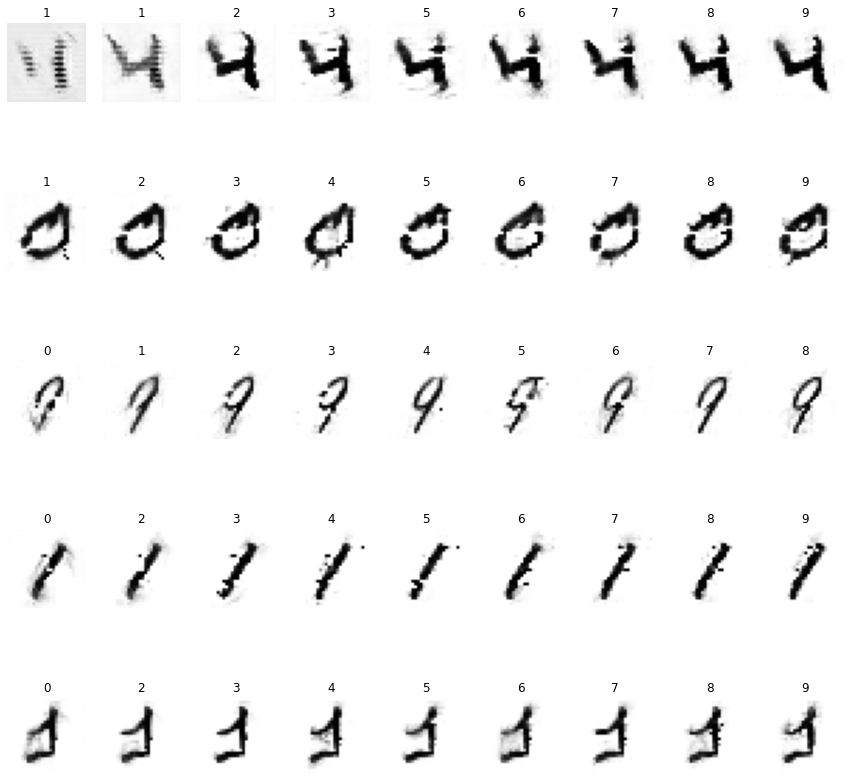

In [10]:
plt.figure(figsize=(15,15))
for i in range(len(generated_images)):
  plt.subplot(len(numbers), (len(classes) - 1), i+1)
  plt.axis('off')
  plt.imshow(generated_images[i].reshape((28,28)), cmap='gray_r')
  plt.title(np.argmax(discriminator.predict(generated_images[i])))
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()

# Comments

From the above images we can see that the GAN could construct pretty good adversarial images except the first one. Although, this might seem odd, our hunch is that it's not an exception because it happens with different sets of images too. The reason we believe that happens is because the weights of the GAN have not been initialized close to the optimal ones. So while on the first try it can't construct an adversarial image without altering much of it, it is sufficient to create weights close to the optimal for the purpose, as it seems from the other images.

# Overcomming the problem

We believe that a way to defend against adversarial attacks is, firstly, by building a deep neural network, capable of discerning many different patterns. Secondly, by augmenting the data (e.g. rotating, width & height shifting and zooming the image) the neural network can achieve better generalization and thus have it's prediction accuracy increased, on new data. Finally, by introducing gaussian noise at the output of each set of layers of the neural network, we can make it develop an even greater generalization ability.

# Deeper Discriminator

The Deeper Discriminator is based on the previous Discriminator architecture and consists of four convolutional layers with a batch-normalization layer, a max-pooling layer and a dropout layer, followed by three fully connected layers with a softmax output of ten classes at the end. In all layers, except the output, we used LeakyReLU as activation function because it has better gradient propagation than sigmoid and tanh and tackles the dying ReLU problem with its slope. We also used batch normalization after all layers except the first convolutional layer where we used L2 regularization in an attempt to normalize the activations of the various layers and reduce overfitting. In addition we used a dropout regularization after each set of layers to reduce overfitting even more. We also used a generalization technique which is adding Gaussian noise at the output after each set of layers. Finally, we used max-pooling after two of the convolutions to reduce the computational cost, by reducing the number of parameters to learn. 

In [11]:
deeper_discriminator = m.Sequential()

deeper_discriminator.add(l.Conv2D(32, kernel_size=5, strides=1, padding='same',
                  input_shape=(28, 28, 1), 
                  kernel_regularizer=r.l2(0.0005)))
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.GaussianNoise(0.2))

deeper_discriminator.add(l.Conv2D(32, kernel_size=5, strides=1, padding='same',
                  use_bias=False))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
deeper_discriminator.add(l.Dropout(0.35))
deeper_discriminator.add(l.GaussianNoise(0.2))

deeper_discriminator.add(l.Conv2D(64, kernel_size=3, strides=1, padding='same',
                  kernel_regularizer=r.l2(0.0005)))
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.GaussianNoise(0.2))

deeper_discriminator.add(l.Conv2D(64, kernel_size=3, strides=1, padding='same',
                  use_bias=False))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
deeper_discriminator.add(l.Dropout(0.35))
deeper_discriminator.add(l.GaussianNoise(0.2))

deeper_discriminator.add(l.Flatten())

deeper_discriminator.add(l.Dense(256, use_bias=False))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.GaussianNoise(0.2))

deeper_discriminator.add(l.Dense(128, use_bias=False))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.GaussianNoise(0.2))

deeper_discriminator.add(l.Dense(84, use_bias=False))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.GaussianNoise(0.2))

deeper_discriminator.add(l.Dense(10, activation='softmax'))

deeper_discriminator.summary()
# plot_model(deeper_discriminator, to_file='deeper_discriminator_plot.png',
#            show_shapes=True, show_layer_names=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        25600     
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)       

# Compilation & Evaluation

For the compilation of the Deeper Discriminator we used as loss function the categorical crossentropy for we had the tags one hot encoded, as optimizer the Adam optimizer and as metrics the accuracy of the predicted images. As far as the training is concerned we had our NN train for twenty five epochs with a decreasing learning rate, while enabling the shuffling of the images in the training set.

In [12]:
def lr_schedule(epoch):
    lrate = 0.0002
    if epoch > 5:
        lrate = 0.0001
    if epoch > 10:
        lrate = 0.00005
    if epoch > 15:
        lrate = 0.00002
    if epoch > 20:
        lrate = 0.00001
    return lrate

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    )
datagen.fit(x_train)

deeper_discriminator.compile(loss='categorical_crossentropy',
                             optimizer=o.Adam(lr=0.0011, decay=1e-6),
                             metrics=['accuracy'])

deeper_discriminator.fit_generator(datagen.flow(x_train, y_train, batch_size=64),
                            epochs=25, shuffle=True,
                            verbose=1, validation_data=(x_test,y_test), 
                            callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


938/938 [==============================] - 29s 29ms/step - loss: 1.6611 - accuracy: 0.4545 - val_loss: 0.3810 - val_accuracy: 0.8863
Epoch 2/25
938/938 [==============================] - 27s 28ms/step - loss: 0.3649 - accuracy: 0.8975 - val_loss: 0.2175 - val_accuracy: 0.9366
Epoch 3/25
938/938 [==============================] - 27s 29ms/step - loss: 0.2318 - accuracy: 0.9360 - val_loss: 0.1017 - val_accuracy: 0.9747
Epoch 4/25
938/938 [==============================] - 27s 29ms/step - loss: 0.1828 - accuracy: 0.9507 - val_loss: 0.0592 - val_accuracy: 0.9866
Epoch 5/25
938/938 [==============================] - 27s 29ms/step - loss: 0.1555 - accuracy: 0.9581 - val_loss: 0.0490 - val_accuracy: 0.9897
Epoch 6/25
938/938 [==============================] - 27s 29ms/step - loss: 0.1375 - accuracy: 0.9636 - val_loss: 0.0409 - val_accuracy: 0.9914
Epoch 7/25
938/938 [==============================] - 27s 28ms/step - loss: 0.1211 - accuracy: 0.9681 - val_loss: 0.0374 - val_accuracy: 0.9928
Epo

# New results

Below we print the adversary images and also the class that the Deeper Discriminator predicts them to be.

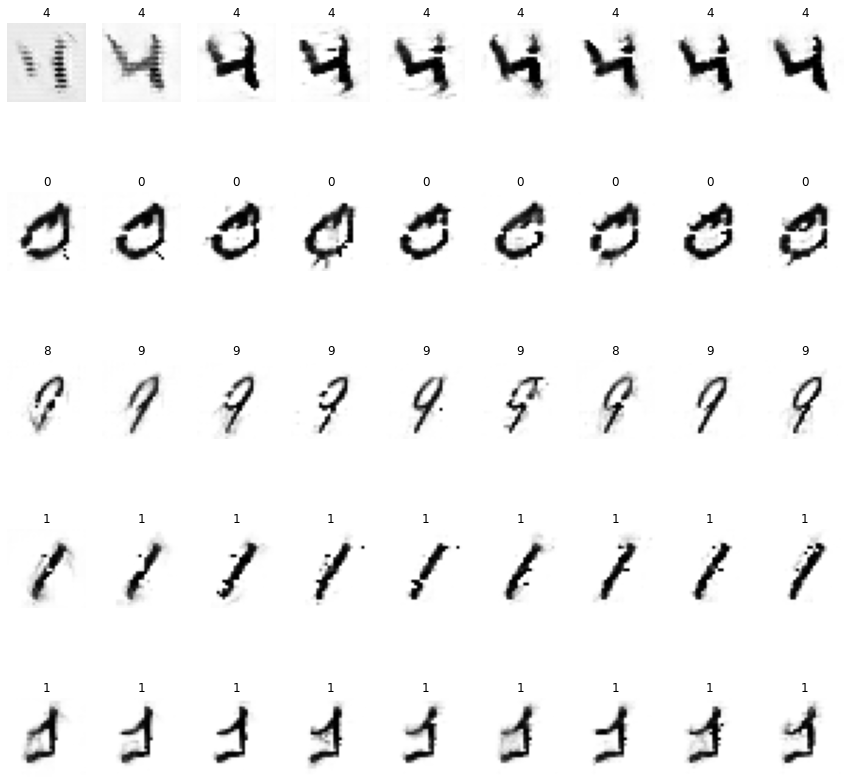

In [13]:
plt.figure(figsize=(15,15))
for i in range(len(generated_images)):
  plt.subplot(len(numbers), (len(classes) - 1), i+1)
  plt.axis('off')
  plt.imshow(generated_images[i].reshape((28,28)), cmap='gray_r')
  plt.title(np.argmax(deeper_discriminator.predict(generated_images[i])))
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()

As we can see from the above results our classifier could correctly predict 43 of 45 adversary images. It's worth mentioning that although these results may vary from training to training because we shuffle the images, the proportion of success remains high. To put it all in a nutshell the second discriminator was able to correctly classify most of the adversarial images that the first was unable to do, because we induced gaussian noise, which resulted in our network having learnt the most significant patterns for each class.